# INDEX
[1. Fruits Classifier](#Fruits-Classifier "Goto Fruits Classifier")<br>
[2. CIFAR-10 on AlexNet](#CIFAR-10 "Goto CIFAR-10")<br>
[2. Fashion MNIST](#Fashion-MNIST "Goto Fashion MNIST")<br>


# Fruits Classifier
[INDEX](#INDEX "Goto INDEX")

In [8]:
import numpy as np
np.random.seed(123)  # for reproducibility
import matplotlib.pyplot as plt

from keras.src.legacy.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import os, shutil

## 1. Loading Data & Data Generator

In [113]:
num_classes = 81
img_rows, img_cols = 32, 32
batch_size = 32

train_images_dir = 'Training'
test_images_dir = 'Test'

# Define image data generators
# perform image augmentation to save model from overfitting the training data
# augmentation will create various batches of images & will apply various transformations on images like flipping
# hence providing the overall more training data without adding anymore images
# shear_range & zoom_range are to define how much randomization we want to apply on data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

# target size: same as input shape in classifier as this will be the input to classifier
# batch_size: number of inputs after which weights will be updated
# class_mode: ['binary', 'categorical']
training_set = train_datagen.flow_from_directory(train_images_dir,
                                                target_size = (img_rows, img_cols),
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                shuffle = True,
                                                seed=67)

test_set = test_datagen.flow_from_directory(test_images_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


## 2. Building & Compiling the CNN

In [26]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# apply various filters to get various layers of image
# 32: number of convolution layers or 2d metrices
# 3,3: size of filter
# padding: 'same', results in padding the input such that the output has same dimension as input
# activation functions: ['relu', 'tanh', 'LeakyReLU']
# rectifier(relu): max(x,0)
# hyperbolic tangent (tanh): (1-e^-2x)/(1+e^-2x)
classifier.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_cols, img_rows, 3)))
classifier.add(Activation('relu'))
classifier.add(Conv2D(32, (3, 3), padding='same'))
classifier.add(Activation('relu'))

# Step 2 - Pooling
# Max Pooling - get 2x2 matrix to filter image by max value
# usually take size 2x2 so that much information is not lost
# in this way assume we have n number of 2d matrix then each matrix represent one specific feature of image
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

# Step 3 - Adding more convolution layers
classifier.add(Conv2D(64, (3, 3), padding='same'))
classifier.add(Activation('relu'))
classifier.add(Conv2D(64, (3, 3), padding='same'))
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

# Step 4 - Flattening
# convert into a single dimensional array where each element contains a feature of image
classifier.add(Flatten())

# Step 5 - Full connection
# fully connected layer or hidden layer
classifier.add(Dense(512))
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

# Step 6 - Ouput Layer
# activation functions: [regression: 'linear', binary classification: 'sigmoid', multiclass: 'softmax']
# sigmoid: 1/(1+e^-x)
# linear: same output
# softmax: converts o/p into a probability distribution for mutliclass problem
classifier.add(Dense(num_classes))
classifier.add(Activation('softmax'))

# Compiling the CNN
# optimizers: ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# loss functions: [regression: ['mse', 'mae', 'logloss'], binary_classification: 'binary_crossentropy', multi_class: 'categorical_crossentropy']
# metrics: ['accuracy', 'precision', 'mse', 'mae']
classifier.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_44 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 64)        18496     
__________

## 3. Define other model parameteres

In [27]:
checkpoint = ModelCheckpoint('fruits.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1
                            )

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.2,
                              min_delta=0.0001,
                              patience=3,
                              verbose=1)

## 4. Fitting the CNN to the images

In [28]:
history = classifier.fit(training_set,
                                   steps_per_epoch = 41322//batch_size,
                                   epochs = 10,
                                   validation_data = test_set,
                                   validation_steps = 13877//batch_size,
                                   callbacks=[checkpoint, earlystop, reduce_lr]
                                  )

Epoch 1/10
1291/1291 [==============================] - 207s 160ms/step - loss: 2.2537 - acc: 0.3273 - val_loss: 0.6667 - val_acc: 0.7553

Epoch 00001: val_loss improved from inf to 0.66669, saving model to fruits.h5
Epoch 2/10
1291/1291 [==============================] - 212s 164ms/step - loss: 0.7017 - acc: 0.7564 - val_loss: 0.2761 - val_acc: 0.9097

Epoch 00002: val_loss improved from 0.66669 to 0.27612, saving model to fruits.h5
Epoch 3/10
1291/1291 [==============================] - 211s 164ms/step - loss: 0.4450 - acc: 0.8457 - val_loss: 0.1838 - val_acc: 0.9339

Epoch 00003: val_loss improved from 0.27612 to 0.18385, saving model to fruits.h5
Epoch 4/10
1291/1291 [==============================] - 210s 162ms/step - loss: 0.3539 - acc: 0.8769 - val_loss: 0.1903 - val_acc: 0.9362

Epoch 00004: val_loss did not improve from 0.18385
Epoch 5/10
1291/1291 [==============================] - 211s 164ms/step - loss: 0.2886 - acc: 0.8986 - val_loss: 0.1900 - val_acc: 0.9291

Epoch 00005:

## 5. Loading Model

In [17]:
# load model
classifier = load_model("fruits.h5")

## 6. Plotting loss and accuracy

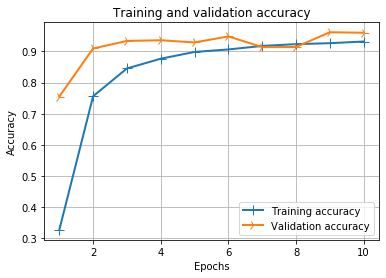

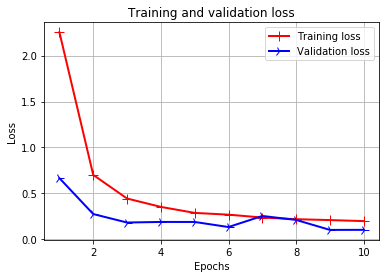

In [29]:
# get dictionary of history data
history_data = history.history

train_accuracy = history_data['acc']
val_accuracy = history_data['val_acc']
train_loss = history_data['loss']
val_loss = history_data['val_loss']
epochs = range(1, len(train_accuracy)+1)

line1 = plt.plot(epochs, train_accuracy, label='Training accuracy')
line2 = plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

line1 = plt.plot(epochs, train_loss, 'r', label='Training loss')
line2 = plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## 7. Evaluating Model

In [114]:
# evaluate performance on test data
test_eval = classifier.evaluate_generator(test_set, steps=13877//batch_size+1, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# confusion matrix and classification report
# reset generator before each prediction
test_set.reset()
y_pred = classifier.predict_generator(test_set, steps=13877//batch_size+1, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
print('\nConfusion Matrix:')
print(confusion_matrix(test_set.classes, y_pred))

print('\nClassification Report:')
class_labels = list({v:k for k,v in test_set.class_indices.items()}.values())
print(classification_report(test_set.classes, y_pred, target_names=class_labels))

434/434 [==============================] - 14s 32ms/step
Test loss: 0.10412361365224301
Test accuracy: 0.960294011673993
434/434 [==============================] - 14s 32ms/step

Confusion Matrix:
[[115  30   2 ...   0   0   0]
 [  0 122  38 ...   0   0   0]
 [  0   0 132 ...   0   0   0]
 ...
 [  0   0   0 ... 132  32   0]
 [  0   0   0 ...   0  95  32]
 [ 27   0   0 ...   0   0 217]]

Classification Report:
                     precision    recall  f1-score   support

     Apple Braeburn       0.57      0.70      0.63       164
     Apple Golden 1       0.80      0.74      0.77       164
     Apple Golden 2       0.73      0.80      0.76       164
     Apple Golden 3       0.76      0.50      0.61       161
 Apple Granny Smith       0.62      0.80      0.70       164
        Apple Red 1       0.80      0.80      0.80       164
        Apple Red 2       0.76      0.60      0.67       164
        Apple Red 3       0.78      0.78      0.78       144
Apple Red Delicious       0.81      0

## 8. Making prediction

Predicted Class: Pear Monster
Actual Class: Pear Monster


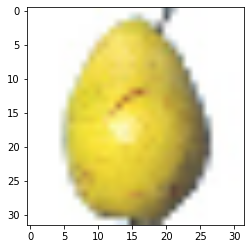

In [95]:
# get all classes folder names
image_folders = os.listdir('Test')
# choose one random folder (0, 81)
folder_index = 56

# get all images in the specified folder
val_images = os.listdir('Test/'+image_folders[folder_index])
index = 50

# load image
test_image = image.load_img('Test/'+image_folders[folder_index]+'/'+val_images[index], target_size=(img_cols, img_rows))
plt.imshow(test_image, interpolation='bilinear')
# convert into array
# dimension = 32, 32, 3
test_image = image.img_to_array(test_image)
# add batch size as 4th dimension
test_image = np.expand_dims(test_image, axis = 0)
# predict on rescaled image
result = classifier.predict(test_image/255)
# get class indices
class_labels = {v:k for k,v in training_set.class_indices.items()}
# get class attributes
print('Predicted Class:', class_labels[np.argmax(result)])
print('Actual Class:', image_folders[folder_index])
plt.show()

## 9. Displaying model Visually

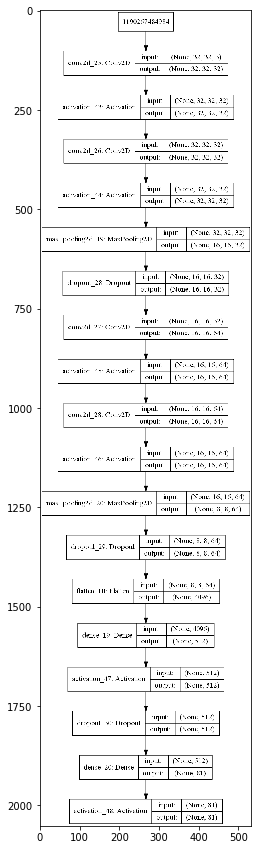

In [44]:
from keras.utils.vis_utils import plot_model

# generate the plot
plot_model(classifier, to_file='fruits.png', show_shapes=True, show_layer_names=True)

# show the plot
img = plt.imread('fruits.png')
plt.figure(figsize=(30,15))
plt.imshow(img)

# CIFAR-10
[INDEX](#INDEX "Goto INDEX")

In [6]:
import numpy as np
np.random.seed(123)  # for reproducibility
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, np_utils

import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Activation, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.datasets import cifar10

from sklearn.metrics import classification_report, confusion_matrix
import os, shutil

## 1. Loading Data

In [5]:
# 1. Load pre-shuffled cifar-10 data into train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
 
# 2. Preprocess input data
# normalize data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
 
# 3. One hot encoding on class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## 2. Building & Compiling the CNN

In [10]:
# Initialising the CNN for AlexNet
classifier = Sequential()

# Conv Layer 1
classifier.add(Conv2D(96, (11, 11), padding='same', 
                      input_shape=(32, 32, 3), kernel_regularizer=l2(0)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Conv Layer 2
classifier.add(Conv2D(256, (5, 5), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Conv Layer 3
classifier.add(ZeroPadding2D((1,1)))
classifier.add(Conv2D(512, (3, 3), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

# Conv Layer 4
classifier.add(ZeroPadding2D((1,1)))
classifier.add(Conv2D(1024, (3, 3), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

# Conv Layer 5
classifier.add(ZeroPadding2D((1,1)))
classifier.add(Conv2D(1024, (3, 3), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
               
# FC Layer 1
classifier.add(Flatten())
classifier.add(Dense(3072))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

# FC Layer 2
classifier.add(Dense(4096))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

# FC Layer 3
classifier.add(Dense(10))
classifier.add(BatchNormalization())
classifier.add(Activation('softmax'))

classifier.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_10 (Activation)   (None, 16, 16, 256)       0         
__________

## 3. Fitting the CNN to the images

In [ ]:
# batch_size: number of inputs after which weights will be updated
batch_size = 32

history = classifier.fit(X_train, Y_train,
                         batch_size = batch_size,
                         epochs = 5,
                         validation_data = (X_test, Y_test),
                         shuffle=True)

## 4. Saving/Loading Model

In [15]:
# saving model
classifier.save("cifar-10_AlexNet.h5")

# load model
classifier = load_model("cifar-10_AlexNet.h5")

## 5. Plotting loss and accuracy

In [ ]:
# get dictionary of history data
history_data = history.history

train_accuracy = history_data['acc']
val_accuracy = history_data['val_acc']
train_loss = history_data['loss']
val_loss = history_data['val_loss']
epochs = range(1, len(train_accuracy)+1)

line1 = plt.plot(epochs, train_accuracy, label='Training accuracy')
line2 = plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

line1 = plt.plot(epochs, train_loss, 'r', label='Training loss')
line2 = plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## 6. Evaluating Model

In [17]:
# evaluate performance on test data
test_eval = classifier.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Confusion matrix and classification report
# support: total no. of records of a particular class
y_pred = classifier.predict(X_test)
print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(confusion_matrix(y_test, np.argmax(y_pred, axis=1)))

10000/10000 [==============================] - 239s 24ms/step
Test loss: 0.8401344166755677
Test accuracy: 0.7183
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1000
           1       0.94      0.75      0.84      1000
           2       0.62      0.68      0.65      1000
           3       0.56      0.49      0.52      1000
           4       0.57      0.82      0.68      1000
           5       0.83      0.39      0.53      1000
           6       0.62      0.91      0.74      1000
           7       0.89      0.71      0.79      1000
           8       0.80      0.90      0.85      1000
           9       0.77      0.85      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.71     10000
weighted avg       0.74      0.72      0.71     10000

[[672   5  71  16 110   2  20   5  77  22]
 [ 24 754  17   3   7   1  35   1  44 114]
 [ 40   0 682  46 104  20  70   9  14  15

## 7. Making prediction

Actual Value: deer
Prediction: deer


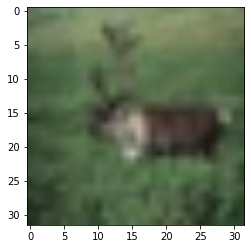

In [20]:
# create class map
class_map = {'0':'airplane', 
             '1':'automobile', 
             '2':'bird', 
             '3':'cat', 
             '4':'deer', 
             '5':'dog', 
             '6':'frog', 
             '7':'horse', 
             '8':'ship', 
             '9':'truck'}

# predict
index = 849
plt.imshow(X_test[index], interpolation='bilinear')
result = classifier.predict(X_test[index].reshape(1, 32, 32, 3))
print('Actual Value:', class_map[str(np.argmax(Y_test[index]))])
print('Prediction:', class_map[str(np.argmax(result))])

## 8. Displaying model Visually

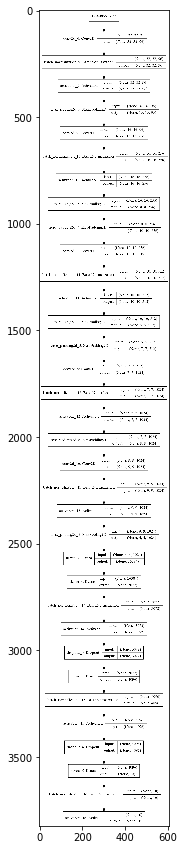

In [14]:
from keras.utils.vis_utils import plot_model

# generate the plot
plot_model(classifier, to_file='cifar10.png', show_shapes=True, show_layer_names=True)

# show the plot
img = plt.imread('cifar10.png')
plt.figure(figsize=(30,15))
plt.imshow(img)

# Fashion MNIST
[INDEX](#INDEX "Goto INDEX")

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, np_utils

import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, Activation, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.datasets import fashion_mnist

from sklearn.metrics import classification_report, confusion_matrix
import os, shutil

Using TensorFlow backend.


## 1. Loading Data

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]
(60000, 28, 28, 1) (10000, 28, 28, 1)


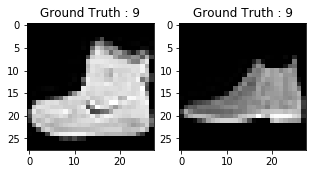

In [3]:
# 1. Load pre-shuffled mnist fasion data into train and test sets
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print('Training data shape : ', X_train.shape, y_train.shape)
print('Testing data shape : ', X_test.shape, y_test.shape)

# Find the unique numbers from the train labels
classes = np.unique(y_train)
num_classes = len(classes)
print('Total number of outputs : ', num_classes)
print('Output classes : ', classes)

img_cols, img_rows = X_train.shape[1:]

plt.figure(figsize=[5,5])
# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_train[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(y_test[0]))

# reshape data as per 28 * 28 *1 for gray scale
X_train = X_train.reshape(-1, 28,28, 1)
X_test = X_test.reshape(-1, 28,28, 1)
print(X_train.shape, X_test.shape)

# 2. Preprocess input data
# convert data from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# convert all pixel values in range of 0 to 1
X_train = X_train / 255.
X_test = X_test / 255.
 
# 3. One hot encoding on class labels
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

## 2. Building & Compiling the CNN

In [11]:
# Initialising the CNN
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_cols, img_rows, 1)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Conv2D(64, (3, 3), padding='same'))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Dropout(0.25))

classifier.add(Flatten())

classifier.add(Dense(128))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.5))

# activation functions: [regression: 'linear', binary classification: 'sigmoid', multiclass: 'softmax']
# sigmoid: 1/(1+e^-x)
# linear: same output
# softmax: converts o/p into a probability distribution for mutliclass problem
classifier.add(Dense(num_classes))
classifier.add(Activation('softmax'))

# Compiling the CNN
# optimizers: ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# loss functions: [regression: ['mse', 'mae', 'logloss'], binary_classification: 'binary_crossentropy', multi_class: 'categorical_crossentropy']
# metrics: ['accuracy', 'precision', 'mse', 'mae']
classifier.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_20 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
__________

## 3. Fitting the CNN to the images

In [12]:
# batch_size: number of inputs after which weights will be updated
batch_size = 32

history = classifier.fit(X_train, Y_train,
                         batch_size = batch_size,
                         epochs = 3,
                         validation_data = (X_test, Y_test),
                         verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 295s 5ms/step - loss: 0.4129 - acc: 0.8563 - val_loss: 0.2862 - val_acc: 0.8957
Epoch 2/3
60000/60000 [==============================] - 271s 5ms/step - loss: 0.2903 - acc: 0.8952 - val_loss: 0.2532 - val_acc: 0.9036
Epoch 3/3
60000/60000 [==============================] - 265s 4ms/step - loss: 0.2488 - acc: 0.9084 - val_loss: 0.2289 - val_acc: 0.9133


## 4. Saving/Loading Model

In [13]:
# saving model
classifier.save("fashion_mnist.h5")

# load model
classifier = load_model("fashion_mnist.h5")

## 5. Plotting loss and accuracy

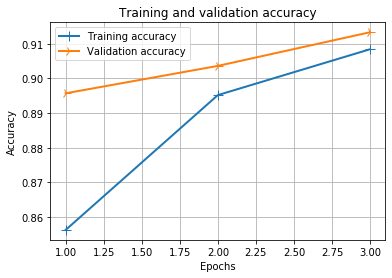

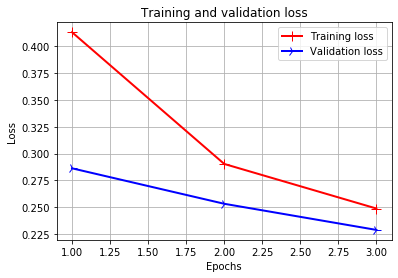

In [14]:
# get dictionary of history data
history_data = history.history

train_accuracy = history_data['acc']
val_accuracy = history_data['val_acc']
train_loss = history_data['loss']
val_loss = history_data['val_loss']
epochs = range(1, len(train_accuracy)+1)

line1 = plt.plot(epochs, train_accuracy, label='Training accuracy')
line2 = plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

line1 = plt.plot(epochs, train_loss, 'r', label='Training loss')
line2 = plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.setp(line1, linewidth=2.0, marker='+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker='4', markersize=10.0)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## 6. Evaluating Model

In [15]:
# evaluate performance on test data
test_eval = classifier.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Confusion matrix and classification report
# support: total no. of records of a particular class
y_pred = classifier.predict(X_test)
print(classification_report(y_test, np.argmax(y_pred, axis=1)))
print(confusion_matrix(y_test, np.argmax(y_pred, axis=1)))

10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.22892028787732124
Test accuracy: 0.9133
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.89      0.84      0.87      1000
           3       0.92      0.91      0.92      1000
           4       0.84      0.89      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.72      0.78      0.75      1000
           7       0.96      0.96      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.95      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000

[[848   0  14  18   1   1 115   0   3   0]
 [  0 984   1   8   3   0   3   0   1   0]
 [ 16   1 842   8  56   0  77   0   0   0]

## 7. Making prediction

Actual Value: Sneaker
Prediction: Sneaker


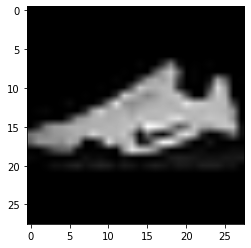

In [32]:
# create class map
class_map = {'0':'T-shirt/Top', 
             '1':'Trouser', 
             '2':'Pullover', 
             '3':'Dress', 
             '4':'Coat', 
             '5':'Sandal', 
             '6':'Shirt', 
             '7':'Sneaker', 
             '8':'Bag', 
             '9':'Ankle Boot'}

# predict
index = 999
plt.imshow(X_test[index][:,:,0], cmap='gray', interpolation='bilinear')
result = classifier.predict(X_test[index].reshape(1, img_rows, img_cols, 1))
print('Actual Value:', class_map[str(np.argmax(Y_test[index]))])
print('Prediction:', class_map[str(np.argmax(result))])

## 8. Displaying model Visually

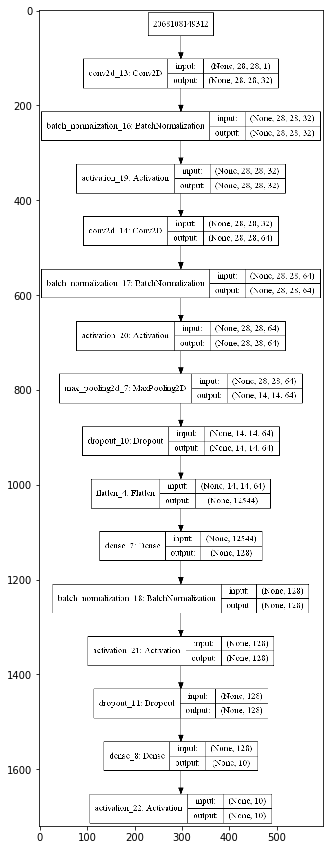

In [33]:
from keras.utils.vis_utils import plot_model

# generate the plot
plot_model(classifier, to_file='fashion_mnist.png', show_shapes=True, show_layer_names=True)

# show the plot
img = plt.imread('fashion_mnist.png')
plt.figure(figsize=(30,15))
plt.imshow(img)